In [2]:
# 데이터 전처리부분 #! 할것! silence 없애고, 멜 노말라이즈

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
from librosa.filters import mel as librosa_mel_fn # 멜 생성
import soundfile as sf

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
import torchaudio
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import io
from PIL import Image

from tqdm import tqdm
from glob import glob

vocoder = torch.hub.load('descriptinc/melgan-neurips', 'load_melgan')


def save_pickle_file(variable, fileName):
    with open(fileName, 'wb') as f:
        pickle.dump(variable, f)


def normalize_mel(wavspath, SAMPLING_RATE=22050):
    wav_files = glob(os.path.join(
        wavspath, '**', '*.wav'), recursive=True) 

    mel_list = []

    for wav_path in tqdm(wav_files, desc='Preprocessing wav to mel'): 
        wave_ori, _ = librosa.load(wav_path, sr=SAMPLING_RATE, mono=True)
        # wave_ori = librosa.effects.trim(wave_ori, top_db = 60) #! remove silence needed 
        spectrogram = vocoder(torch.tensor([wave_ori])) 
        mel_list.append(spectrogram.cpu().detach().numpy()[0])

    mel_concatenated = np.concatenate(mel_list, axis=1)
    #! normlized needed
    return mel_concatenated


def preprocess_dataset(data_path, speaker_id, cache_folder):

    """Preprocesses dataset of .wav files by converting to Mel-spectrograms.
    Args:
        data_path (str): Directory containing .wav files of the speaker.
        speaker_id (str): ID of the speaker.
        cache_folder (str, optional): Directory to hold preprocessed data.
    """

    print(f"Preprocessing data for speaker: {speaker_id}.")

    mel_concat = normalize_mel(data_path)

    if not os.path.exists(os.path.join(cache_folder, speaker_id)):
        os.makedirs(os.path.join(cache_folder, speaker_id))




    idx = 1
    num1 = 0
    num2 = 80
    
    save_pickle_file(variable = mel_concat, fileName = os.path.join(cache_folder, f"{speaker_id}_normalized_full.pickle"))
    # while num2 < mel_concat[1].shape[0]: #80 단위별로 끊기
    #     print(f"index{idx}")
    #     save_pickle(variable=mel_concat[:, num1:num2],
    #                 fileName=os.path.join(cache_folder, f"{speaker_id}_{idx}_normalized.pickle"))
    #     num1 += 81
    #     num2 += 81
    #     idx += 1

    print(f"Preprocessed and saved data for the speaker: {speaker_id}.")


/home/yuholee/.conda/envs/Test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/yuholee/.cache/torch/hub/descriptinc_melgan-neurips_master
/home/yuholee/.cache/torch/hub/descriptinc_melgan-neurips_master/mel2wav/modules.py:42: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=None as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [ ]:
preprocess_dataset("/home/yuholee/develop/data_KR/train/B_M_14_t", "B_M_14_t", "/home/yuholee/develop/data_KR/train_mel/B_M_14_t")

(80, 46047)
torch.Size([288, 432, 3])


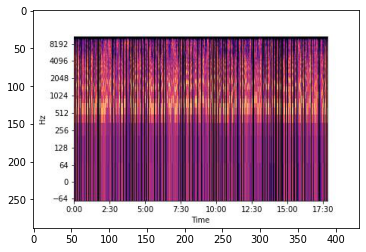

In [6]:
# 각각저장된 멜 확인

def load_pickle_file(fileName):
    with open(fileName, 'rb') as f:
        return pickle.load(f)
        

def get_mel_spectrogram_fig(spec, title="Mel-Spectrogram"):
    """Generates a figure of the Mel-spectrogram and converts it to a tensor.

    Args:
        spec (torch.Tensor): Mel-spectrogram
        title (str, optional): Figure name. Defaults to "Mel-Spectrogram".

    Returns:
        torch.Tensor: Figure as tensor
    """
    figure, ax = plt.subplots()
    canvas = FigureCanvas(figure)
    S_db = librosa.power_to_db(10**spec.squeeze(), ref=np.max)
    img = librosa.display.specshow(S_db, ax=ax, y_axis='log', x_axis='time')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
        
    image = Image.open(buf)
    image = ToTensor()(image)
    
    plt.close(figure)
    return image

# 멜 확인해보기
sample_mel = load_pickle_file("/home/yuholee/develop/data_KR/eval_mel/A_F_02_e/A_F_02_e_normalized_full.pickle")
print(sample_mel.shape)

mel = get_mel_spectrogram_fig(sample_mel) # a: (C, H, W)
mel = mel.permute(1,2,0)  # a: (H, W, C)
print(mel.size())
plt.imshow(mel)



# 학습된 멜 그려보기

In [26]:
def load_pickle_file(fileName):
    with open(fileName, 'rb') as f:
        return pickle.load(f)


a = load_pickle_file("/home/yuholee/develop/ViTCycleGAN_Mel/saved_mels/0_mel_y.pickle")

print(type(a))
print(a.shape)
a = a.cpu()
a = a.detach().numpy()

<class 'torch.Tensor'>
torch.Size([5, 1, 80, 80])


In [33]:
a[0].squeeze()

(1, 80, 80)

torch.Size([288, 432, 3])


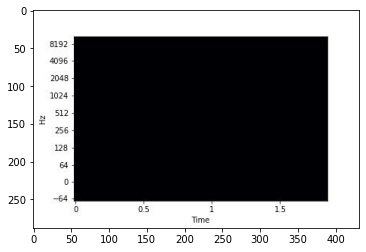

In [40]:
mel = get_mel_spectrogram_fig(a[1].squeeze()) # a: (C, H, W)
mel = mel.permute(1,2,0)  # a: (H, W, C)
print(mel.size())
plt.imshow(mel)
